# Stable Diffusion KLMC2 Animation

<div>
<img src="https://images.squarespace-cdn.com/content/v1/6213c340453c3f502425776e/a432c21c-bb12-4f38-b5e2-1c12a3c403f6/Animated-Logo_1.gif" width="150"/>
</div>


Notebook by [Katherine Crowson](https://twitter.com/RiversHaveWings), modified by [David Marx](https://twitter.com/DigThatData).

Sponsored by [StabilityAI](https://twitter.com/stabilityai)

Generate animations with [Stable Diffusion](https://stability.ai/blog/stable-diffusion-public-release) 1.4, using the [KLMC2 discretization of underdamped Langevin dynamics](https://arxiv.org/abs/1807.09382). The notebook is largely inspired by [Ajay Jain](https://twitter.com/ajayj_) and [Ben Poole](https://twitter.com/poolio)'s paper [Journey to the BAOAB-limit](https://www.ajayjain.net/journey)&mdash;thank you so much for it!

---

## Modifications Provenance

Original notebook URL - [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1m8ovBpO2QilE2o4O-p2PONSwqGn4_x2G)

Features and QOL Modifications by [David Marx](https://twitter.com/DigThatData) - [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dmarx/notebooks/blob/main/Stable_Diffusion_KLMC2_Animation.ipynb)

Last updated date (effectively, notebook version): 2022-01-30

* Keyframed prompts and settings
* Multiprompt conditioning w independent prompt schedules
* Set seed for deterministic output
* Mount Google Drive
* Faster Setup
* Init image
* Alt-checkpoint loading consistent w/deforum
* Set output filename
* Fancy GPU info
* Video embed optional
* ~~Cheaper default runtime~~ torn about this
* Local setup
* New VAE option
* Smooth interpolation for settings curves
* Settings curves specified via simple DSL
* Exposed `refinement_steps` parameter
* Custom output resolution
* Optional video upscale
* Optional resume
* Optional archival
* Assorted refactoring

## Local Setup

Download the repo containing this notebook and supplementary setup files.

```
git clone https://github.com/dmarx/notebooks
cd notebooks
```

Strongly recommend setting up and activating a virtual environment first. Here's one option that is built into python, windows users in particular might want to consider using anaconda as an alternative.

```bash
python3 -m venv _venv
source _venv/bin/activate
pip install jupyter
```

With this venv created, in the future you only need to run `source _venv/bin/activate` to activate it.

You can now start a local jupyter instance from the terminal in which the virtual environment is activated by running the `jupyter` command, or alternatively select the new virtualenv as the python environment in your IDE of choice. When you run the notebook's setup cells, it should detect that local setup needs to be performed and modify its setup procedure appropriately.

A common source of errors is user confusion between the python environment running the notebook and an intended virtual environment into which setup has already been performed. To validate that you are using the python environment you think you are, run the command `which python` (this locates the executable associated with the `python` command) both inside the notebook and in a terminal in which your venv is activated: the results should be identical.

## Contact

Report bugs or feature ideas here: https://github.com/dmarx/notebooks/issues

In [ ]:
#@title Check GPU
#!nvidia-smi

import pandas as pd
import subprocess

def gpu_info():
    outv = subprocess.run([
        'nvidia-smi',
            # these lines concatenate into a single query string
            '--query-gpu='
            'timestamp,'
            'name,'
            'utilization.gpu,'
            'utilization.memory,'
            'memory.used,'
            'memory.free,'
            ,
        '--format=csv'
        ],
        stdout=subprocess.PIPE).stdout.decode('utf-8')

    header, rec = outv.split('\n')[:-1]
    return pd.DataFrame({' '.join(k.strip().split('.')).capitalize():v for k,v in zip(header.split(','), rec.split(','))}, index=[0]).T

gpu_info()

In [ ]:
#@title Install Dependencies

# @markdown Your runtime will automatically restart after running this cell.
# @markdown You should only need to run this cell when setting up a new runtime. After future runtime restarts,
# @markdown you should be able to skip this cell.

import warnings

probably_using_colab = False
try:
    import google
    probably_using_colab = True
except ImportError:
    warnings.warn("Unable to import `google`, assuming this means we're using a local runtime")

# @markdown Not recommended for colab users. This notebook is currently configured to only make this
# @markdown option available for local install.
use_xformers = False

try:
    import keyframed
except ImportError:
    if probably_using_colab:
        !pip install ftfy einops braceexpand requests transformers clip open_clip_torch omegaconf pytorch-lightning kornia k-diffusion ninja omegaconf
        !pip install -U git+https://github.com/huggingface/huggingface_hub
        !pip install napm keyframed
    else:
        !pip install -r klmc2/requirements.txt
        if use_xformers:
            !pip install -v -U git+https://github.com/facebookresearch/xformers.git@main#egg=xformers

    exit() # restarts the runtime

In [ ]:
# @markdown # Setup Workspace { display-mode: "form" }

###################
# Setup Workspace #
###################

import os
from pathlib import Path
import warnings

probably_using_colab = False
try:
    import google
    if Path('/content').exists():
        probably_using_colab = True
        print("looks like we're in colab")
    else:
        print("looks like we're not in colab")
except ImportError:
    warnings.warn("Unable to import `google`, assuming this means we're using a local runtime")


mount_gdrive = True # @param {type:'boolean'}

# defaults
outdir = Path('./frames')
if not os.environ.get('XDG_CACHE_HOME'):
    os.environ['XDG_CACHE_HOME'] = str(Path('~/.cache').expanduser())

if mount_gdrive and probably_using_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    Path('/content/drive/MyDrive/AI/models/.cache/').mkdir(parents=True, exist_ok=True) 
    os.environ['XDG_CACHE_HOME']='/content/drive/MyDrive/AI/models/.cache'
    outdir = Path('/content/drive/MyDrive/AI/klmc2/frames/')

# make sure the paths we need exist
outdir.mkdir(parents=True, exist_ok=True)
os.environ['NAPM_PATH'] = str( Path(os.environ['XDG_CACHE_HOME']) / 'napm' )
Path(os.environ['NAPM_PATH']).mkdir(parents=True, exist_ok=True)


import napm

url = 'https://github.com/Stability-AI/stablediffusion'
napm.pseudoinstall_git_repo(url, add_install_dir_to_path=True)


##### Moved from model loading cell

if probably_using_colab:
    models_path = "/content/models" #@param {type:"string"}
else:
    models_path =  os.environ['XDG_CACHE_HOME']

if mount_gdrive and probably_using_colab:
    models_path_gdrive = "/content/drive/MyDrive/AI/models" #@param {type:"string"}
    models_path = models_path_gdrive

if not Path(models_path).exists():
    Path(models_path).mkdir(parents=True, exist_ok=True)


In [ ]:
# @markdown # Imports and Definitions { display-mode: "form" }

###########
# imports #
###########

# importing napm puts the stable diffusion repo on the PATH, which is where `ldm` imports from
import napm
from ldm.util import instantiate_from_config

from base64 import b64encode
from collections import defaultdict
from concurrent import futures
import math
from pathlib import Path
import random
import re
import requests
from requests.exceptions import HTTPError
import sys
import time
from urllib.parse import urlparse
import warnings

import functorch
import huggingface_hub
from IPython.display import display, Video, HTML
import k_diffusion as K
from keyframed import Curve, ParameterGroup, Keyframe, register_interpolation_method
from keyframed.curve import bisect_left_keyframe, bisect_right_keyframe
import matplotlib.pyplot as plt
import numpy as np 
from omegaconf import OmegaConf
from PIL import Image
import torch
from torch import nn
from tqdm.auto import tqdm, trange

from loguru import logger
import time
from natsort import natsorted

#########################
# Define useful globals #
#########################

cpu = torch.device("cpu")
device = torch.device("cuda")

##############################
# Define necessary functions #
##############################

def sin2(t):
    return (math.sin(t * math.pi / 2)) ** 2

# to do: turn this into a decorator in dmarx/Keyframed
def eased_lerp(k, curve, ease=sin2):
    left = bisect_left_keyframe(k, curve)
    right = bisect_right_keyframe(k, curve)
    xs = [left.t, right.t]
    ys = [left.value, right.value]

    span = xs[1]-xs[0]
    t = (k-xs[0]) / span
    t_new = ease(t)
    return ys[1] * t_new + ys[0] * (1-t_new)

register_interpolation_method('eased_lerp', eased_lerp)


def SmoothCurve(*args, **kargs):
    """
    out of the box, the default interpolation method is "previous".
    This is just a thin wrapper to use the 'eased_lerp' interpolation defined above instead.
    """
    return Curve(*args, default_interpolation='eased_lerp', **kargs)


class Prompt:
    def __init__(
        self,
        text,
        weight_schedule,
    ):
        c = sd_model.get_learned_conditioning([text])
        self.text=text
        self.encoded=c
        self.weight=Curve(
            weight_schedule, 
            default_interpolation='eased_lerp', 
        )

##################

def handle_chigozienri_curve_format(value_string):
    if value_string.startswith('(') and value_string.endswith(')'):
        value_string = value_string[1:-1]
    return value_string

def parse_curve_string(txt, f=float):
    schedule = {}
    for tokens in txt.split(','):
        k,v = tokens.split(':')
        v = handle_chigozienri_curve_format(v)
        schedule[int(k)] = f(v)
    return schedule

def parse_curvable_string(param, is_int=False):
    if isinstance(param, dict):
        return param
    f = float
    if is_int:
        f = int
    try:
        return f(param)
    except ValueError:
        return parse_curve_string(txt=param, f=f)


##################

class NormalizingCFGDenoiser(nn.Module):
    def __init__(self, model, g):
        super().__init__()
        self.inner_model = model
        self.g = g
        self.eps_norms = defaultdict(lambda: (0, 0))

    def mean_sq(self, x):
        return x.pow(2).flatten(1).mean(1)

    @torch.no_grad()
    def update_eps_norm(self, eps, sigma):
        sigma = sigma[0].item()
        eps_norm = self.mean_sq(eps).mean()
        eps_norm_avg, count = self.eps_norms[sigma]
        eps_norm_avg = eps_norm_avg * count / (count + 1) + eps_norm / (count + 1)
        self.eps_norms[sigma] = (eps_norm_avg, count + 1)
        return eps_norm_avg

    def forward(self, x, sigma, uncond, cond, g):
        x_in = torch.cat([x] * 2)
        sigma_in = torch.cat([sigma] * 2)
        cond_in = torch.cat([uncond, cond])

        denoised = self.inner_model(x_in, sigma_in, cond=cond_in)
        eps = K.sampling.to_d(x_in, sigma_in, denoised)
        eps_uc, eps_c = eps.chunk(2)
        eps_norm = self.update_eps_norm(eps, sigma).sqrt()
        c = eps_c - eps_uc
        cond_scale = g * eps_norm / self.mean_sq(c).sqrt()
        eps_final = eps_uc + c * K.utils.append_dims(cond_scale, x.ndim)
        return x - eps_final * K.utils.append_dims(sigma, eps.ndim)

#########################

def write_klmc2_state(**state):
    st = time.time()
    obj = {}
    for k,v in state.items():
        try:
            v = v.clone().detach().cpu()
        except AttributeError:
            # if it doesn't have a detach method, we don't need to worry about any preprocessing
            pass
        obj[k] = v

    checkpoint_fpath = Path(outdir) / f"klmc2_state_{state.get('i',0):05}.ckpt"
    with open(checkpoint_fpath, 'wb') as f:
        torch.save(obj, f=f)
    et = time.time()
    logger.debug(f"checkpointing: {et-st}")
    # to do: move to callback? thread executor, anyway

def read_klmc2_state(root=outdir, latest_frame=-1):
    state = {}
    checkpoints = [str(p) for p in Path(root).glob("*.ckpt")]
    if not checkpoints:
        return None
    if latest_frame < 0:
        ckpt_fpath = natsorted(checkpoints)[-1]
    else:
        for fname in checkpoints:
            frame_id = re.findall(r'([0-9]+).ckpt', fname)
            if int(frame_id) <= latest_frame:
                ckpt_fpath = fname
            else:
                break
    logger.debug(ckpt_fpath)
    with open(ckpt_fpath,'rb') as f:
        #state = torch.load(f=f,map_location=x.device)
        state = torch.load(f=f,map_location='cuda')
    return state

def load_init_image(init_image, height, width):
    if not Path(init_image).exists():
        raise FileNotFoundError(f"Unable to locate init image from path: {init_image}")
    
    
    from PIL import Image
    import numpy as np

    init_im_pil = Image.open(init_image)

    #x_pil = init_im_pil.resize([512,512])
    x_pil = init_im_pil.resize([height,width])
    x_np = np.array(x_pil.convert('RGB')).astype(np.float16) / 255.0
    x = x_np[None].transpose(0, 3, 1, 2)
    x = 2.*x - 1.
    x = torch.from_numpy(x).to('cuda')
    return x

def save_image_fn(image, name, i, n):
    pil_image = K.utils.to_pil_image(image)
    if i % 10 == 0 or i == n - 1:
        print(f'\nIteration {i}/{n}:')
        display(pil_image)
    if i == n - 1:
        print('\nDone!')
    pil_image.save(name)

###############################

@torch.no_grad()
def sample_mcmc_klmc2(
    sd_model, 
    init_image,
    height,
    width,
    n, 
    hvp_method='reverse', 
    prompts=None,
    settings=None,
    resume = False,
    resume_from=-1,
    img_init_steps=None,
):

    torch.cuda.empty_cache()

    wrappers = {'eps': K.external.CompVisDenoiser, 'v': K.external.CompVisVDenoiser}
    g = settings[0]['g']

    model_wrap = wrappers[sd_model.parameterization](sd_model)
    model_wrap_cfg = NormalizingCFGDenoiser(model_wrap, g)
    sigma_min, sigma_max = model_wrap.sigmas[0].item(), model_wrap.sigmas[-1].item()
    model = model_wrap_cfg

    uc = sd_model.get_learned_conditioning([''])
    extra_args = {
        'uncond': uc, 
        #'cond': prompts[0].encoded,
        'g': settings[0]['g']
    }

    sigma = settings[0]['sigma']

    with torch.cuda.amp.autocast(), futures.ThreadPoolExecutor() as ex:
        def callback(info):
            i = info['i']
            rgb = sd_model.decode_first_stage(info['denoised'] )
            ex.submit(save_image_fn, rgb, outdir / f'out_{i:05}.png', i, n)

        # Initialize the chain
        print('Initializing the chain...')

        # to do: if resuming, generating this init image is unnecessary
        x = None
        if init_image:
            print("loading init image")
            x = load_init_image(init_image, height, width)
            # convert RGB to latent
            x = sd_model.get_first_stage_encoding(sd_model.encode_first_stage(x))
            print("init image loaded.")

        # to do: isolate multicond so we can use it for init image
        if x is None:
            print("No init image provided, generating a random init image")
            extra_args['cond'] = prompts[0].encoded
            h=height//8
            w=width//8
            x = torch.randn([1, 4, h, w], device=device) * sigma_max
            sigmas_pre = K.sampling.get_sigmas_karras(img_init_steps, sigma, sigma_max, device=x.device)[:-1]
            x = K.sampling.sample_dpmpp_sde(model_wrap_cfg, x, sigmas_pre, extra_args=extra_args)

        print('Actually doing the sampling...')

        i_resume=0
        v = None
        if resume:
            state = read_klmc2_state(latest_frame=resume_from)
            if state:
                x, v, i_resume = state['x'], state['v'], state['i']
        # if not resuming, randomly initialize momentum
        if v is None:
            v = torch.randn_like(x) * sigma

        # main sampling loop
        for i in trange(n):
            # fast-forward loop to resumption index
            if resume and i < i_resume:
                continue

            h = settings[i]['h']
            gamma = settings[i]['gamma']
            alpha = settings[i]['alpha']
            tau = settings[i]['tau']
            g = settings[i]['g']
            sigma = settings[i]['sigma']
            steps = settings[i]['steps']

            h = torch.tensor(h, device=x.device)
            gamma = torch.tensor(gamma, device=x.device)
            alpha = torch.tensor(alpha, device=x.device)
            tau = torch.tensor(tau, device=x.device)
            sigma = torch.tensor(sigma, device=x.device)
            steps = int(steps)
            
            sigmas = K.sampling.get_sigmas_karras(steps, sigma_min, sigma.item(), device=x.device)[:-1]

            x, v, grad = klmc2_step(
                model,
                prompts,
                x,
                v,
                h,
                gamma,
                alpha,
                tau,
                g,
                sigma,
                sigmas,
                steps,
                hvp_method,
                i,
                callback,
                extra_args,
            )

            save_checkpoint = (i % 10) == 0
            if save_checkpoint:
                ex.submit(write_klmc2_state, v=v, x=x, i=i)


def hvp_fn_forward_functorch(model, x, sigma, v, alpha, extra_args):
    def grad_fn(x, sigma):
        s_in = x.new_ones([x.shape[0]])
        denoised = model(x, sigma * s_in, **extra_args)
        return (x - denoised) + alpha * x
    jvp_fn = lambda v: functorch.jvp(grad_fn, (x, sigma), (v, torch.zeros_like(sigma)))
    grad, jvp_out = functorch.vmap(jvp_fn)(v)
    return grad[0], jvp_out

def hvp_fn_reverse(model, x, sigma, v, alpha, extra_args):
    def grad_fn(x, sigma):
        s_in = x.new_ones([x.shape[0]])
        denoised = model(x, sigma * s_in, **extra_args)
        return (x - denoised) + alpha * x
    vjps = []
    with torch.enable_grad():
        x_ = x.clone().requires_grad_()
        grad = grad_fn(x_, sigma)
        for k, item in enumerate(v):
            vjp_out = torch.autograd.grad(grad, x_, item, retain_graph=k < len(v) - 1)[0]
            vjps.append(vjp_out)
    return grad, torch.stack(vjps)

def hvp_fn_zero(model, x, sigma, v, alpha, extra_args):
    def grad_fn(x, sigma):
        s_in = x.new_ones([x.shape[0]])
        denoised = model(x, sigma * s_in, **extra_args)
        return (x - denoised) + alpha * x
    return grad_fn(x, sigma), torch.zeros_like(v)

def hvp_fn_fake(model, x, sigma, v, alpha, extra_args):
    def grad_fn(x, sigma):
        s_in = x.new_ones([x.shape[0]])
        denoised = model(x, sigma * s_in, **extra_args)
        return (x - denoised) + alpha * x
    return grad_fn(x, sigma), (1 + alpha) * v


def multicond_hvp(model, x, sigma, v, alpha, extra_args, prompts, hvp_fn, i):

    # loop over prompts and aggregate gradients for multicond
    grad = torch.zeros_like(x)
    h2_v = torch.zeros_like(x)
    h2_noise_v2 = torch.zeros_like(x)
    h2_noise_x2 = torch.zeros_like(x)
    wt_norm = 0
    for prompt in prompts:
        wt = prompt.weight[i]
        if wt == 0:
            continue
        wt_norm += wt
        wt = torch.tensor(wt, device=x.device)
        extra_args['cond'] = prompt.encoded

        # Estimate gradient and hessian
        grad_, (h2_v_, h2_noise_v2_, h2_noise_x2_) = hvp_fn(
            model=model,
            x=x, 
            sigma=sigma, 
            v=v,
            alpha=alpha,
            extra_args=extra_args,
        )

        grad = grad + grad_ * wt 
        h2_v = h2_v + h2_v_ * wt
        h2_noise_v2 = h2_noise_v2 + h2_noise_v2_ * wt
        h2_noise_x2 = h2_noise_x2 + h2_noise_x2_ * wt

    # Normalize gradient to magnitude it'd have if just single prompt w/ wt=1.
    # simplifies multicond w/o deep frying image or adding hyperparams
    grad = grad / wt_norm 
    h2_v = h2_v / wt_norm
    h2_noise_v2 = h2_noise_v2 / wt_norm
    h2_noise_x2 = h2_noise_x2 / wt_norm

    return grad, h2_v, h2_noise_v2, h2_noise_v2, h2_noise_x2




def klmc2_step(
            model,
            prompts,
            x,
            v,
            h,
            gamma,
            alpha,
            tau,
            g,
            sigma,
            sigmas,
            steps,
            hvp_method,
            i,
            callback,
            extra_args,
        ):

    #s_in = x.new_ones([x.shape[0]])

    # Model helper functions

    hvp_fns = {'forward-functorch': hvp_fn_forward_functorch,
                'reverse': hvp_fn_reverse,
                'zero': hvp_fn_zero,
                'fake': hvp_fn_fake}

    hvp_fn = hvp_fns[hvp_method]

    # KLMC2 helper functions
    def psi_0(gamma, t):
        return torch.exp(-gamma * t)

    def psi_1(gamma, t):
        return -torch.expm1(-gamma * t) / gamma

    def psi_2(gamma, t):
        return (torch.expm1(-gamma * t) + gamma * t) / gamma ** 2

    def phi_2(gamma, t_):
        t = t_.double()
        out = (torch.exp(-gamma * t) * (torch.expm1(gamma * t) - gamma * t)) / gamma ** 2
        return out.to(t_)

    def phi_3(gamma, t_):
        t = t_.double()
        out = (torch.exp(-gamma * t) * (2 + gamma * t + torch.exp(gamma * t) * (gamma * t - 2))) / gamma ** 3
        return out.to(t_)


    # Compute model outputs and sample noise
    x_trapz = torch.linspace(0, h, 1001, device=x.device)
    y_trapz = [fun(gamma, x_trapz) for fun in (psi_0, psi_1, phi_2, phi_3)]
    noise_cov = torch.tensor([[torch.trapz(y_trapz[i] * y_trapz[j], x=x_trapz) for j in range(4)] for i in range(4)], device=x.device)
    noise_v, noise_x, noise_v2, noise_x2 = torch.distributions.MultivariateNormal(x.new_zeros([4]), noise_cov).sample(x.shape).unbind(-1)

    extra_args['g']=g

    # compute derivatives, multicond wrapper loops over prompts and averages derivatives
    grad, h2_v, h2_noise_v2, h2_noise_v2, h2_noise_x2 = multicond_hvp(
        model=model, 
        x=x, 
        sigma=sigma, 
        v=torch.stack([v, noise_v2, noise_x2]), # need a "dummy" v for init image generation
        alpha=alpha, 
        extra_args=extra_args, 
        prompts=prompts, 
        hvp_fn=hvp_fn,
        i=i,
    )

    # DPM-Solver++(2M) refinement steps
    x_refine = x
    use_dpm = True
    old_denoised = None
    for j in range(len(sigmas) - 1):
        if j == 0:
            denoised = x_refine - grad
        else:
            s_in = x.new_ones([x.shape[0]])
            denoised = model(x_refine, sigmas[j] * s_in, **extra_args)
        dt_ode = sigmas[j + 1] - sigmas[j]
        if not use_dpm or old_denoised is None or sigmas[j + 1] == 0:
            eps = K.sampling.to_d(x_refine, sigmas[j], denoised)
            x_refine = x_refine + eps * dt_ode
        else:
            h_ode = sigmas[j].log() - sigmas[j + 1].log()
            h_last = sigmas[j - 1].log() - sigmas[j].log()
            fac = h_ode / (2 * h_last)
            denoised_d = (1 + fac) * denoised - fac * old_denoised
            eps = K.sampling.to_d(x_refine, sigmas[j], denoised_d)
            x_refine = x_refine + eps * dt_ode
        old_denoised = denoised
    if callback is not None:
        callback({'i': i, 'denoised': x_refine})

    # Update the chain
    noise_std = (2 * gamma * tau * sigma ** 2).sqrt()
    v_next = 0 + psi_0(gamma, h) * v - psi_1(gamma, h) * grad - phi_2(gamma, h) * h2_v + noise_std * (noise_v - h2_noise_v2)
    x_next = x + psi_1(gamma, h) * v - psi_2(gamma, h) * grad - phi_3(gamma, h) * h2_v + noise_std * (noise_x - h2_noise_x2)
    v, x = v_next, x_next

    return x, v, grad 

In [ ]:
#@markdown **Select and Load Model**

## TO DO:
## - if local, try to load model from ~/.cache/huggingface/diffusers

# modified from:
#   https://github.com/deforum/stable-diffusion/blob/main/Deforum_Stable_Diffusion.ipynb

import napm
from ldm.util import instantiate_from_config


model_config = "v1-inference.yaml" #@param ["custom","v1-inference.yaml"]
model_checkpoint =  "sd-v1-4.ckpt" #@param ["custom","sd-v1-4-full-ema.ckpt","sd-v1-4.ckpt","sd-v1-3-full-ema.ckpt","sd-v1-3.ckpt","sd-v1-2-full-ema.ckpt","sd-v1-2.ckpt","sd-v1-1-full-ema.ckpt","sd-v1-1.ckpt", "robo-diffusion-v1.ckpt","waifu-diffusion-v1-3.ckpt"]
if model_checkpoint == "waifu-diffusion-v1-3.ckpt":
    model_checkpoint = "model-epoch05-float16.ckpt"
custom_config_path = "" #@param {type:"string"}
custom_checkpoint_path = "" #@param {type:"string"}

half_precision = True # check
check_sha256 = False #@param {type:"boolean"}

model_map = {
    "sd-v1-4-full-ema.ckpt": {
        'sha256': '14749efc0ae8ef0329391ad4436feb781b402f4fece4883c7ad8d10556d8a36a',
        'url': 'https://huggingface.co/CompVis/stable-diffusion-v-1-2-original/blob/main/sd-v1-4-full-ema.ckpt',
        'requires_login': True,
        },
    "sd-v1-4.ckpt": {
        'sha256': 'fe4efff1e174c627256e44ec2991ba279b3816e364b49f9be2abc0b3ff3f8556',
        'url': 'https://huggingface.co/CompVis/stable-diffusion-v-1-4-original/resolve/main/sd-v1-4.ckpt',
        'requires_login': True,
        },
    "sd-v1-3-full-ema.ckpt": {
        'sha256': '54632c6e8a36eecae65e36cb0595fab314e1a1545a65209f24fde221a8d4b2ca',
        'url': 'https://huggingface.co/CompVis/stable-diffusion-v-1-3-original/blob/main/sd-v1-3-full-ema.ckpt',
        'requires_login': True,
        },
    "sd-v1-3.ckpt": {
        'sha256': '2cff93af4dcc07c3e03110205988ff98481e86539c51a8098d4f2236e41f7f2f',
        'url': 'https://huggingface.co/CompVis/stable-diffusion-v-1-3-original/resolve/main/sd-v1-3.ckpt',
        'requires_login': True,
        },
    "sd-v1-2-full-ema.ckpt": {
        'sha256': 'bc5086a904d7b9d13d2a7bccf38f089824755be7261c7399d92e555e1e9ac69a',
        'url': 'https://huggingface.co/CompVis/stable-diffusion-v-1-2-original/blob/main/sd-v1-2-full-ema.ckpt',
        'requires_login': True,
        },
    "sd-v1-2.ckpt": {
        'sha256': '3b87d30facd5bafca1cbed71cfb86648aad75d1c264663c0cc78c7aea8daec0d',
        'url': 'https://huggingface.co/CompVis/stable-diffusion-v-1-2-original/resolve/main/sd-v1-2.ckpt',
        'requires_login': True,
        },
    "sd-v1-1-full-ema.ckpt": {
        'sha256': 'efdeb5dc418a025d9a8cc0a8617e106c69044bc2925abecc8a254b2910d69829',
        'url':'https://huggingface.co/CompVis/stable-diffusion-v-1-1-original/resolve/main/sd-v1-1-full-ema.ckpt',
        'requires_login': True,
        },
    "sd-v1-1.ckpt": {
        'sha256': '86cd1d3ccb044d7ba8db743d717c9bac603c4043508ad2571383f954390f3cea',
        'url': 'https://huggingface.co/CompVis/stable-diffusion-v-1-1-original/resolve/main/sd-v1-1.ckpt',
        'requires_login': True,
        },
    "robo-diffusion-v1.ckpt": {
        'sha256': '244dbe0dcb55c761bde9c2ac0e9b46cc9705ebfe5f1f3a7cc46251573ea14e16',
        'url': 'https://huggingface.co/nousr/robo-diffusion/resolve/main/models/robo-diffusion-v1.ckpt',
        'requires_login': False,
        },
    "model-epoch05-float16.ckpt": {
        'sha256': '26cf2a2e30095926bb9fd9de0c83f47adc0b442dbfdc3d667d43778e8b70bece',
        'url': 'https://huggingface.co/hakurei/waifu-diffusion-v1-3/resolve/main/model-epoch05-float16.ckpt',
        'requires_login': False,
        },
}

# config path
ckpt_config_path = custom_config_path if model_config == "custom" else os.path.join(models_path, model_config)
if os.path.exists(ckpt_config_path):
    print(f"{ckpt_config_path} exists")
else:
    #ckpt_config_path = "./stable-diffusion/configs/stable-diffusion/v1-inference.yaml"
    ckpt_config_path = "./v1-inference.yaml"
    if not Path(ckpt_config_path).exists():
        !wget https://raw.githubusercontent.com/CompVis/stable-diffusion/main/configs/stable-diffusion/v1-inference.yaml
    
print(f"Using config: {ckpt_config_path}")

# checkpoint path or download
ckpt_path = custom_checkpoint_path if model_checkpoint == "custom" else os.path.join(models_path, model_checkpoint)
ckpt_valid = True
if os.path.exists(ckpt_path):
    print(f"{ckpt_path} exists")
elif 'url' in model_map[model_checkpoint]:
    url = model_map[model_checkpoint]['url']

    # CLI dialogue to authenticate download
    if model_map[model_checkpoint]['requires_login']:
        print("This model requires an authentication token")
        print("Please ensure you have accepted its terms of service before continuing.")

        username = input("What is your huggingface username?:")
        token = input("What is your huggingface token?:")

        _, path = url.split("https://")

        url = f"https://{username}:{token}@{path}"

    # contact server for model
    print(f"Attempting to download {model_checkpoint}...this may take a while")
    ckpt_request = requests.get(url)
    request_status = ckpt_request.status_code

    # inform user of errors
    if request_status == 403:
      raise ConnectionRefusedError("You have not accepted the license for this model.")
    elif request_status == 404:
      raise ConnectionError("Could not make contact with server")
    elif request_status != 200:
      raise ConnectionError(f"Some other error has ocurred - response code: {request_status}")

    # write to model path
    with open(os.path.join(models_path, model_checkpoint), 'wb') as model_file:
        model_file.write(ckpt_request.content)
else:
    print(f"Please download model checkpoint and place in {os.path.join(models_path, model_checkpoint)}")
    ckpt_valid = False

if check_sha256 and model_checkpoint != "custom" and ckpt_valid:
    import hashlib
    print("\n...checking sha256")
    with open(ckpt_path, "rb") as f:
        bytes = f.read() 
        hash = hashlib.sha256(bytes).hexdigest()
        del bytes
    if model_map[model_checkpoint]["sha256"] == hash:
        print("hash is correct\n")
    else:
        print("hash in not correct\n")
        ckpt_valid = False

if ckpt_valid:
    print(f"Using ckpt: {ckpt_path}")

def load_model_from_config(config, ckpt, verbose=False, device='cuda', half_precision=True):
    map_location = "cuda" #@param ["cpu", "cuda"]
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location=map_location)
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    if half_precision:
        model = model.half().to(device)
    else:
        model = model.to(device)
    model.eval()
    return model

if ckpt_valid:
    local_config = OmegaConf.load(f"{ckpt_config_path}")
    model = load_model_from_config(local_config, f"{ckpt_path}", half_precision=half_precision)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model = model.to(device)

    # Disable checkpointing as it is not compatible with the method
    for module in model.modules():
        if hasattr(module, 'checkpoint'):
            module.checkpoint = False
        if hasattr(module, 'use_checkpoint'):
            module.use_checkpoint = False

    sd_model=model

####################################################################

use_new_vae = True #@param {type:"boolean"}

if use_new_vae:

    # from kat's notebook again

    def download_from_huggingface(repo, filename):
        while True:
            try:
                return huggingface_hub.hf_hub_download(repo, filename)
            except HTTPError as e:
                if e.response.status_code == 401:
                    # Need to log into huggingface api
                    huggingface_hub.interpreter_login()
                    continue
                elif e.response.status_code == 403:
                    # Need to do the click through license thing
                    print(f'Go here and agree to the click through license on your account: https://huggingface.co/{repo}')
                    input('Hit enter when ready:')
                    continue
                else:
                    raise e

    vae_840k_model_path = download_from_huggingface("stabilityai/sd-vae-ft-mse-original", "vae-ft-mse-840000-ema-pruned.ckpt")

    def load_model_from_config_kc(config, ckpt):
        print(f"Loading model from {ckpt}")
        pl_sd = torch.load(ckpt, map_location="cpu")
        sd = pl_sd["state_dict"]
        config = OmegaConf.load(config)

        try:
            config['model']['params']['lossconfig']['target'] = "torch.nn.Identity"
            print('Patched VAE config.')
        except KeyError:
            pass

        model = instantiate_from_config(config.model)
        m, u = model.load_state_dict(sd, strict=False)
        model = model.to(cpu).eval().requires_grad_(False)
        return model

    vaemodel_yaml_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/models/first_stage_models/kl-f8/config.yaml"
    vaemodel_yaml_fname = 'config_vae_kl-f8.yaml'
    vaemodel_yaml_fname_git = "latent-diffusion/models/first_stage_models/kl-f8/config.yaml"
    if Path(vaemodel_yaml_fname_git).exists():
        vae_model = load_model_from_config_kc(vaemodel_yaml_fname_git, vae_840k_model_path).half().to(device)
    else:
        if not Path(vaemodel_yaml_fname).exists():
            !wget {vaemodel_yaml_url} -O {vaemodel_yaml_fname}
        vae_model = load_model_from_config_kc(vaemodel_yaml_fname, vae_840k_model_path).half().to(device)

    del sd_model.first_stage_model
    sd_model.first_stage_model = vae_model

In [ ]:
# @title Settings

# @markdown The number of frames to sample:
n = 500 # @param {type:"integer"}

# @markdown height and width must be multiples of 8 (e.g. 256, 512, 768, 1024)
height = 512 # @param {type:"integer"}

width = 512 # @param {type:"integer"}


# @markdown If seed is negative, a random seed will be used
seed = 1178162299  # @param {type:"number"}

init_image = "" # @param {type:'string'}

# @markdown ---

# @markdown Settings below this line can be parameterized using keyframe syntax:  `"time:weight, time:weight, ...".  
# @markdown Over spans where values of weights change, intermediate values will be interpolated using an "s" shaped curve.
# @markdown If a value for keyframe 0 is not specified, it is presumed to be `0:0`.

# @markdown The strength of the conditioning on the prompt:
g = "0:0.1" # @param {type:"string"}

# @markdown The noise level to sample at
# @markdown Ramp up from a tiny sigma if using init image, e.g. `0:0.25, 100:2, ...`
# @markdown NB: Turning sigma *up* mid generation seems to work fine, but turning sigma *down* mid generation tends to "deep fry" the outputs
sigma = "1.25" # @param {type:"string"}

# @markdown Step size (range 0 to 1):
h = "0:0.13" # @param {type:"string"}

# @markdown Friction (2 is critically damped, lower -> smoother animation):
gamma = "1.5" # @param {type:"string"}

# @markdown Quadratic penalty ("weight decay") strength:
alpha = "0.001" # @param {type:"string"}

# @markdown Temperature (adjustment to the amount of noise added per step):
tau = "1.0" # @param {type:"string"}

# @markdown Denoising refinement steps:
refinement_steps = "6" # @param {type:"string"}

# @markdown If an init image is not provided, this is how many steps will be used when generating an initial state:
img_init_steps = 15 # @param {type:"number"}

# @markdown The HVP method:
# @markdown <br><small>`forward-functorch` and `reverse` provide real second derivatives. Compatibility, speed, and memory usage vary by model and xformers configuration.
# @markdown `fake` is very fast and low memory but inaccurate. `zero` (fallback to first order KLMC) is not recommended.</small>
hvp_method = 'fake' ## 'reverse' # @param ["forward-functorch", "reverse", "fake", "zero"]


###########################

assert (height % 8) == 0
assert (width % 8) == 0

In [ ]:
#@title Prompts

#  [  
#    ["first prompt will be used to initialize the image", {time:weight, time:weight...}], 
#    ["more prompts if you want", {...}], 
#  ...]

# if a weight for time=0 isn't specified, the weight is assumed to be zero.


prompt_params = [
    # # FIRST PROMPT INITIALIZES IMAGE
    #["sweetest puppy, golden retriever", {0:.5, 30:0.5, 100:0}],
    #["sweet old dog, golden retriever", {0:0, 30:0, 100:0.5}],
    #["happiest pupper, cutest dog evar, golden retriever, incredibly photogenic dog", {0:1}],

    # # the 'flowers prompts' below go with a particular 'h' setting in the next cell
    # ["incredibly beautiful orchids, a bouquet of orchids", {0:1, 35:1, 50:0}],
    # ["incredibly beautiful roses, a bouquet of roses", {0:0.001, 35:0.001, 50:1, 120:1, 140:0}],
    # ["incredibly beautiful carnations, a bouquet of carnations", {0:0.001, 120:0.001, 140:1, 220:1, 240:0}],
    # ["incredibly beautiful carnations, a bouquet of sunflowers", {0:0.001, 220:0.001, 240:1}],

    ["deepdream, inceptionism feature activations, beautiful, art made with deep learning, flowing fluid dynamics, creative psychedlic portrait of phenomenology of perception, /r/deepdream, modern art, incredible, amazing, by unkown contemporary artist", {0:1}],
    #["by alex grey, oil on canvas", {0:0.0001, 300:0.0001, 400:0.3}],
    # Negative Prompts
    ["watermark text", {0:-0.1} ],
    ["jpeg artifacts", {0:-0.1} ],
]


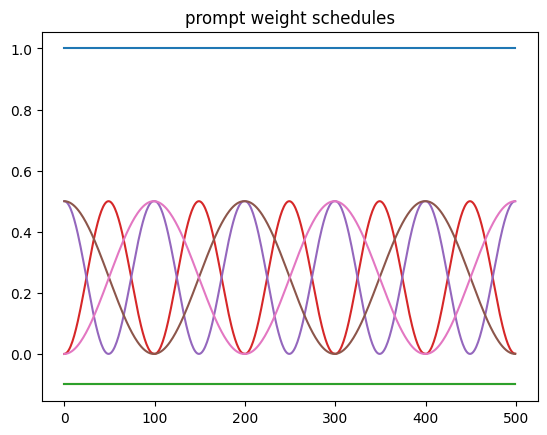

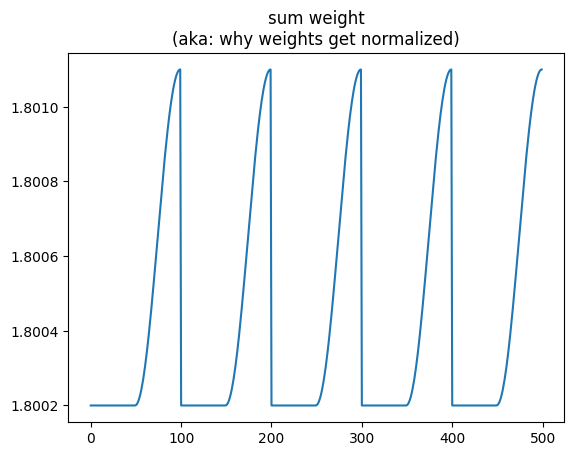

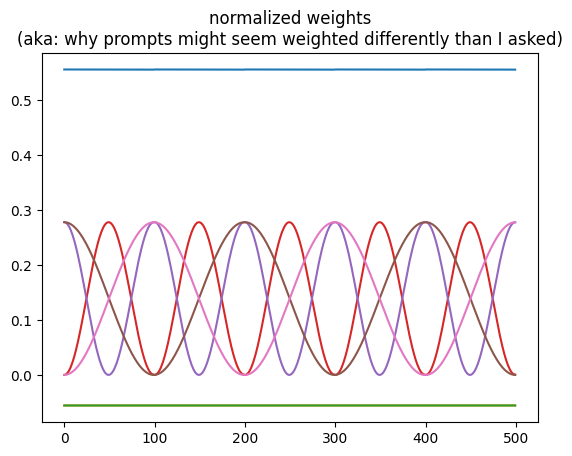

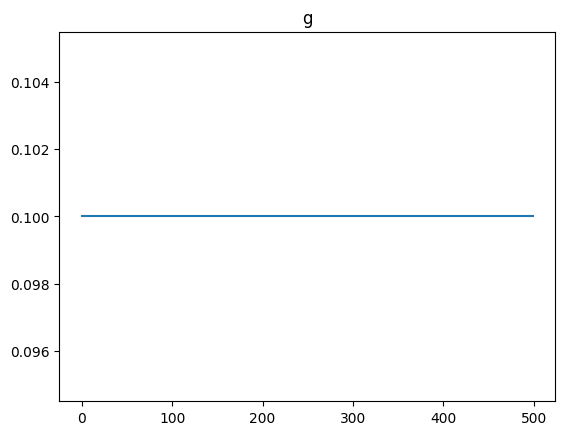

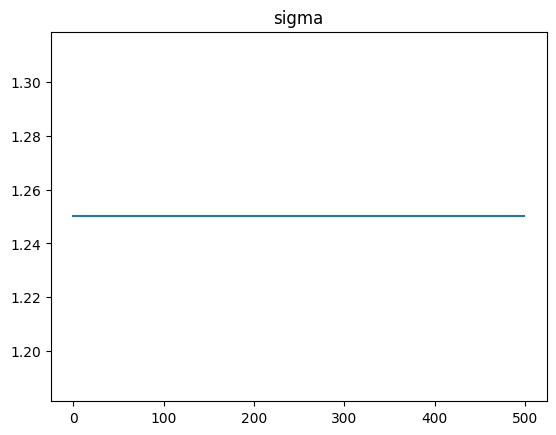

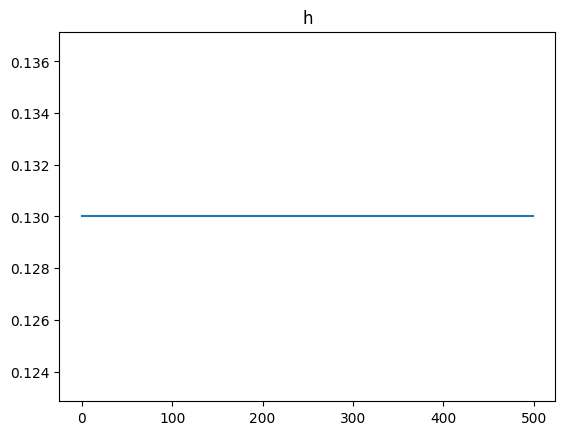

0.8788815153266635
0.9379395109390702
0.8931290751339009
0.8628890018682255
0.8592760234117913
0.907329145889853
0.9087891311941444
0.9528139921080121
0.9618773529894042
1.129433823501041
1.0752988746319894
0.9723990076916897
0.897512242985475
0.8926302400838381
0.8584327864664129
0.8831423116146953
0.8159466951187929
0.715779383565429
0.5375051954290951
0.6174843274669037
0.7321636110919347
0.7654526350518672
0.9001301396032966
0.787566774775282
0.7832110467490028
0.7534540828824675
0.8558120784057539
0.6591738104284206
0.49444284864648874
0.6120381771392207
0.715022357672556
0.6445059370143312
0.6320606776673979
0.5867010176221947
0.6395526367009363
0.751018736391108
0.9073284370726149
0.8676863208268604
0.9218727277001573
0.888859932517952
0.858787417981819
0.9781256573276789
1.04312222064077
1.1748813115704235
1.3233008820020349
1.4253111305561015
1.3985305269012804
1.4727325518015975
1.4296215417140408
1.6043731041314966
1.7935792111680722
1.6946398795879847
1.630384402337356
1.58

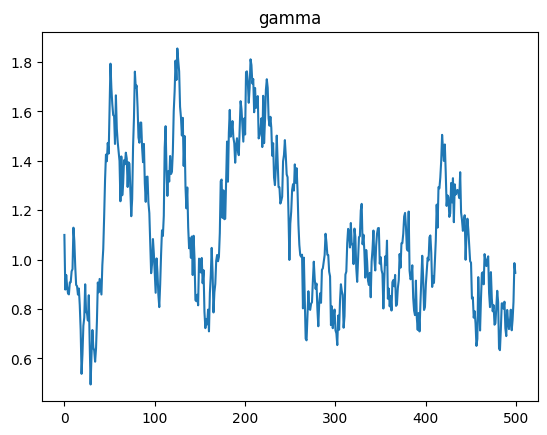

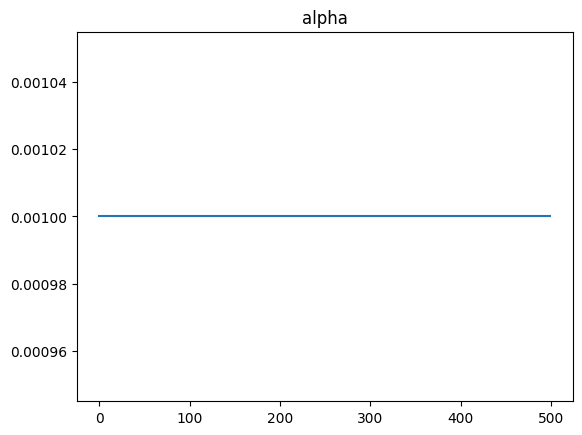

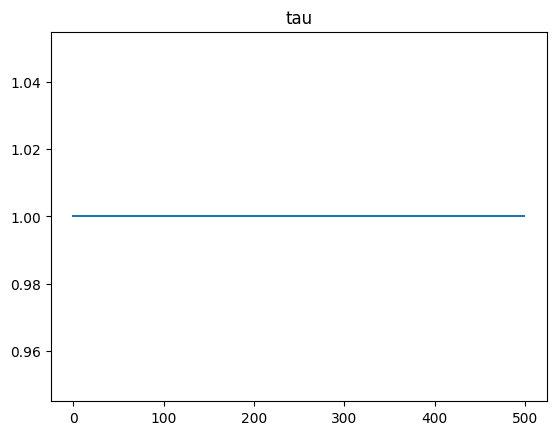

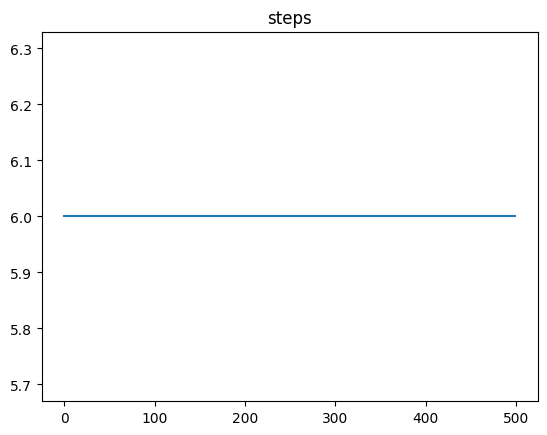

In [52]:
# @title Build prompt and settings objects

plot_prompt_weight_curves = True # @param {type: 'boolean'}
plot_settings_weight_curves = True # @param {type: 'boolean'}

#################


prompts = [
    Prompt(text, weight_schedule) 
    for (text, weight_schedule) in prompt_params
]

hi = 0.5
artists_loop_params = [
    ["a beautiful painting, oil on canvas", {0:0.0001, 49:hi, 99:0.001}],
    ["a beautiful painting, watercolor", {0:hi, 49:0.0001, 99:hi}],
    ["painted by wasily kandinsky", {0:hi, 99:0.0001, 199:hi}],
    ["painted by chuck", {0:0.0001, 99:hi, 199:0.0001}],
] 

artists_loop_prompts = [
    Prompt(text, weight_schedule) 
    for (text, weight_schedule) in artists_loop_params
]

for p in artists_loop_prompts:
    p.weight.loop=True
prompts.extend(artists_loop_prompts)

g = parse_curvable_string(g)
sigma = parse_curvable_string(sigma)
h = parse_curvable_string(h)
gamma = parse_curvable_string(gamma)
alpha = parse_curvable_string(alpha)
tau = parse_curvable_string(tau)
steps = parse_curvable_string(refinement_steps)

PREVIOUS = 1
def constrained_random_walk(*args, step_size=None, lower=.7, upper=2):
    u = random.random()
    s = 1 if u > 0.5 else -1
    if step_size is None:
        #step_size = u/4
        step_size = random.gauss(0,.1)
    step = s*step_size
    global PREVIOUS
    new = PREVIOUS + step
    #new = min(upper, new)
    if new > upper:
        new = PREVIOUS - step_size
    if new < lower:
        new = PREVIOUS + step_size
    PREVIOUS = new
    #print(PREVIOUS)
    return PREVIOUS

curved_settings = ParameterGroup({
    'g':SmoothCurve(g),
    'sigma':SmoothCurve(sigma),
    'h':SmoothCurve(h),

    # w/flowers prompts:
    #'h':SmoothCurve({0:0.1, 30:0.1, 50:0.3, 70:0.1, 90:0.1}, loop=True),
    
    #'gamma':SmoothCurve(gamma),
    'gamma':Curve({0:1.1}, default_interpolation=constrained_random_walk),
    'alpha':SmoothCurve(alpha),
    'tau':SmoothCurve(tau),
    'steps':SmoothCurve(steps),
})


if plot_prompt_weight_curves:
    xs = np.array(range(n))
    ytot=np.array([0 for _ in range(n)])
    for prompt in prompts:
        ys = np.array([prompt.weight[x] for x in xs])
        ytot=ytot+ys
        plt.plot(xs, ys)
    plt.title("prompt weight schedules")
    plt.show()

    plt.plot(xs, ytot)
    plt.title("sum weight\n(aka: why weights get normalized)")
    plt.show()

    for prompt in prompts:#[:3]:
        xs = np.array(range(n))
        ys = np.array([prompt.weight[x] for x in xs])
        plt.plot(xs, ys/ytot)
    plt.title("normalized weights\n(aka: why prompts might seem weighted differently than I asked)")
    plt.show()

if plot_settings_weight_curves:
    xs = np.array(range(n))
    for param_name, param_curve in curved_settings.parameters.items():
        ys = np.array([param_curve[x] for x in xs])
        plt.plot(xs, ys)
        plt.title(param_name)
        plt.show()

In [ ]:
#@title Generate Animation Frames

resume = False # @param{type:'boolean'}
archive_old_work = True # @param{type:'boolean'}

resume_from = 80 # -1 = most recent from

_seed = seed
if seed < 0:    
    _seed = random.randrange(0, 4294967295)
print(f"using seed: {_seed}")
torch.manual_seed(_seed)

if not resume:
    if archive_old_work:
        archive_dir = outdir.parent / 'archive' / str(int(time.time()))
        archive_dir.mkdir(parents=True, exist_ok=True)
        print("Archiving contents of /frames, moving to: {archive_dir}")
    else:
        print("Old contents of /frames being deleted. This can be prevented in the future by setting either 'resume' or 'archive_old_work' to True.")
    for p in outdir.glob(f'*'):
        if archive_old_work:
            target = archive_dir / p.name
            p.rename(target)
        else:
            p.unlink()


sample_mcmc_klmc2(
    sd_model=sd_model,
    init_image=init_image,
    height=height,
    width=width,
    n=n,
    hvp_method=hvp_method,
    prompts=prompts,
    settings=curved_settings,
    resume=resume,
    resume_from=resume_from,
    img_init_steps=img_init_steps,
)


In [ ]:
#@title Make the video


# @markdown If your video is larger than a few MB, attempting to embed it will probably crash
# @markdown the session. If this happens, view the generated video after downloading it first.
embed_video = True # @param {type:'boolean'}
download_video = False # @param {type:'boolean'}

upscale_video = False  # @param {type:'boolean'}


outdir_str = str(outdir)

fps = 12 # @param {type:"integer"}
out_fname = "out.mp4" # @param {type: "string"}

out_fullpath = str( outdir / out_fname )
print(f"Video will be saved to: {out_fullpath}")

compile_video_cmd = f"ffmpeg -y -r {fps} -i 'out_%*.png' -crf 15 -preset veryslow -pix_fmt yuv420p " # {out_fname}"
if upscale_video:
    compile_video_cmd += f"-vf scale={2*width}x{2*height}:flags=lanczos "
compile_video_cmd += f"{out_fname}"

print('\nMaking the video...\n')
!cd {outdir_str}; {compile_video_cmd}

if embed_video:
    print('\nThe video:')
    display(Video(out_fullpath))

if download_video and probably_using_colab:
    from google.colab import files
    files.download(out_fullpath)

In [ ]:
#@title Licensed under the MIT License { display-mode: "form" }

# Copyright (c) 2022 Katherine Crowson <crowsonkb@gmail.com>
# Copyright (c) 2023 David Marx <david.marx84@gmail.com>
# Copyright (c) 2022 deforum and contributors

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.